# Spam Detection
**W. Evan Durno**

In this analysis I run through a simple machine learning task: spam detection. This notebook illustrates the whole analytic process. Like most data science projects, this one progresses iteratively. Each cycle can be described with the following steps.

1. Exploring data
2. Strategy implementation
3. Strategy evaluation

# 0. Load libraries
Be sure to have these libraries installed if you want to run this code.

In [19]:
import pandas as pa 
import numpy as np
import sklearn as sk 
from sklearn.cross_validation import train_test_split
import re
import matplotlib.pyplot as plt
import gensim # word2vec 
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB

# Cycle 1 - Largely exploratory
The first attempt at solving a data science problem tends to be a highly informative failure, and this cycle is no exception. However, the process produces valuable insights and data products which are used in the final cycle.

## 1A Exploring data

#### Loading and formatting data

Data are loaded from a CSV and formatted for readability and later ease-of-use later. Of utmost importance, training and testing data and randomly separated. The testing data set will not be utilized untill the evaluation phase. 

In [20]:
# load data 
df = pa.DataFrame.from_csv( 'spam.csv' , index_col=None )

# use logical column names  
df.rename( columns = { df.columns[0] : 'is_spam' , df.columns[1] : 'strings' } , inplace=True )

# Extract training and testing data 
train , test = train_test_split( df , test_size=0.2 ) 

# load stop words 
stop_words = open('stopwords.txt').readlines()
stop_words = [ re.sub( '[\n]' , '' , s ) for s in stop_words ]

def prepare_data ( t=train ) : 
    # Convert strings to vectors of clean words
    def str_to_vec ( s ) : 
        s = re.sub('[.,\'\"]','',s) 
        s = s.lower() 
        return [ word for word in s.split() if word not in stop_words ]
    str_vec = [ str_to_vec(s) for s in t[ 'strings' ] ] 
    def to_ascii ( s ) : 
        return [ ord(c) for c in s ]
    # convert strings to ascii 
    ascii = [ to_ascii( s ) for s in t[ 'strings' ] ] 
    # numerically represent classes: ham: 0, spam: 1 
    labels =[ { 'ham' : 0 , 'spam' : 1 }[x] for x in t['is_spam'] ] 
    return( ( labels , str_vec , ascii ) )

train_labels , train_vec , train_ascii = prepare_data( train ) 
test_labels , test_vec , test_ascii = prepare_data( test ) 

#### Descriptive statistics
The primary goal of data exploration is to gain meaningful insights into **featurization** and **strategic modelling**. Data exploration is an inherently messy process, so comments will be made throughout.

Ratio spam: 0.105707106963
Longest string: 910


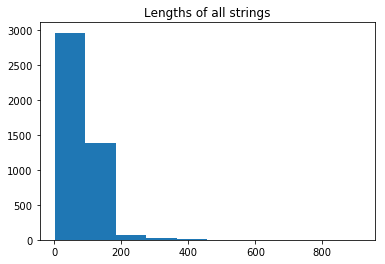

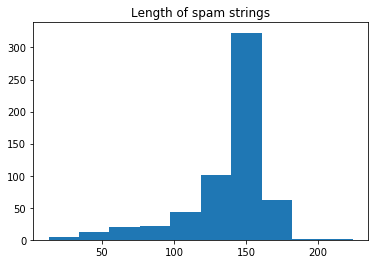

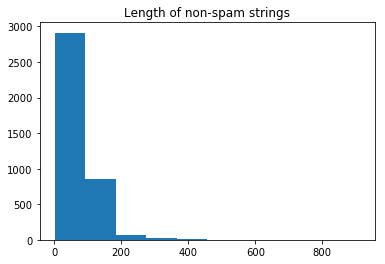

In [21]:
# Useful summary statistics follow 
# ham relative to spam 
n_ham = np.sum( [ x == 'ham' for x in train[ 'is_spam' ] ] )
n_spam = np.sum( [ x == 'spam' for x in train[ 'is_spam' ] ] )
# percent spam 
print( 'Ratio spam: ' + str( n_spam / float(df.shape[0])) )  

# Longest string 
print( 'Longest string: ' + str(np.max( [ len(x) for x in train['strings'] ] )) )  

# length histogram 
plt.hist( [ len(x) for x in train['strings'] ] )
plt.title( 'Lengths of all strings' ) 
plt.show() 

# spam length histogram 
plt.hist( [ len(train['strings'].iloc[i]) for i in range( train.shape[0] ) if train['is_spam'].iloc[i] == 'spam' ] ) 
plt.title( 'Length of spam strings' ) 
plt.show() 

# ham length histogram 
plt.hist( [ len(train['strings'].iloc[i]) for i in range( train.shape[0] ) if train['is_spam'].iloc[i] == 'ham' ] ) 
plt.title( 'Length of non-spam strings' ) 
plt.show() 

## 1B Strategy implementation
We can see that spam strings tend to have a particular range of lengths relative to non-spam string lengths, making string length a target for **featurization**. We will now attempt to vectorize the text using word2vec. Separation will be demonstrated visually with a dimensional reduction technique (**t-SNE**).

In [22]:
# length feature 
def featurize_length( s = train['strings'].iloc[0] ) : 
    l = len(s) 
    if l > 90 and l < 175 : 
        return 1
    return 0 

## t-SNE 
w2v_size = 100 
w2v_model = gensim.models.Word2Vec( train_vec , min_count=3 , size = w2v_size ) 

# Featurize with word2vec
def w2v_featurize ( vec = train_vec[0] ) : 
    return [ w2v_model[ s ] for s in vec if s in w2v_model.wv.vocab ] 

train_w2v_tmp = [ w2v_featurize( s ) for s in train_vec ] 

# how many sentences did not survive this pipeline? 
dead_sentences = np.sum( [ len( x ) == 0 for x in train_w2v_tmp ] ) 
print( 'Ratio of data destroyed by the word2vec pipeline: ' + str( dead_sentences / float( len( train_w2v_tmp ) ) ) ) 

Ratio of data destroyed by the word2vec pipeline: 0.012340139107


#### Insight: 
The **w2v_featurize** function must be updated to handle destroyed data. 

In [23]:
def w2v_featurize_2 ( vec = train_vec[0] ) : 
    t = [ w2v_model[ s ] for s in vec if s in w2v_model.wv.vocab ] 
    if len(t) == 0 : 
            return [0] * w2v_size 
    return np.mean( t , axis=0 ) # sentnce representation as individual vectors  

train_w2v = np.asarray( [ w2v_featurize_2( s ) for s in train_vec ] ) 

print( 'Training data (n_samples, n_dim): ' + str( train_w2v.shape ) ) 

Training data (n_samples, n_dim): (4457, 100)


## 1C Strategy evaluation
To evaluate the **word2vec** featurization, a **t-SNE** will be used to search for separation in data.

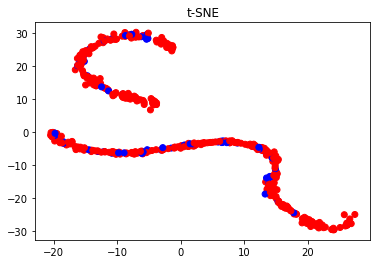

In [24]:
# subset data prior to running t-SNE, thereby making compute times tractable. 
t_sne_sub_size = 500 
t_sne_sub_idx = np.random.choice( train_w2v.shape[0] , t_sne_sub_size , replace = False ) 
t_sne_x = np.asarray( [ train_w2v[i,:] for i in t_sne_sub_idx ] ) 
t_sne_y = [ train_labels[i] for i in t_sne_sub_idx ] 

# Now to dimensionally reduce with a t-SNE 
train_w2v_embedded = TSNE(n_components=2).fit_transform( X = t_sne_x , y = t_sne_y ) 

# viz time 
colour_codes = [ { 0 : 'r' , 1 : 'b' }[ x ] for x in t_sne_y ] 
plt.scatter( train_w2v_embedded[:,0] , train_w2v_embedded[:,1] , c = colour_codes ) 
plt.title('t-SNE')
plt.show()

#### Insight:
Reliance on word2vec does not seem to produce any separation in the data. These features will not be used! I will now attempt a Naive Bayes approach.

# Cycle 2 - Naive Bayes

## 2A Exploring data
Most data formatting is already done. Only some featurization remains. We will use a multinomial Naive Bayes classifier, counting words to classify spam. As a bonus, we will use the string-length feature discovered earlier as an additional feature.

In [25]:
## Multinomial Naive Bayes featurization 
# Get all words 
train_strings = ''.join( train['strings'] ) # concatenate all strings  
train_strings = re.sub('[.,\'\"]','', train_strings ) # remove useless characters  
train_strings = train_strings.lower() # to lower case 
train_strings = [ word for word in train_strings.split() if word not in stop_words ] # split by spaces and remove stop words
df_ts = pa.DataFrame( train_strings , columns=['words'] )
nb_min_obs = 4
val_counts = df_ts['words'].value_counts()
print( 'Number of words observed at least ' + str(nb_min_obs) + ' times: ' + str(np.sum( val_counts > nb_min_obs )) ) 

# the Naive Bayes words list   
nb_words = [ val_counts.index[i] for i in range(len(val_counts.index)) if val_counts[i] > nb_min_obs ] 

def nb_featurize ( s=train['strings'].iloc[0] ) : 
    # format words 
    s = re.sub('[.,\'\"]','', s ) 
    s = s.lower() 
    s = [ word for word in s.split() if word not in stop_words ] 
    # count words 
    d = dict( zip( nb_words , [0]*len(nb_words) ) ) 
    d['UNSEEN_WORDS'] = 0 
    for word in s : 
        try : 
            d[ word ] += 1 
        except : 
            d['UNSEEN_WORDS'] += 1 
    count_features = d.values() 
    # now featurize length  
    count_features.append( featurize_length( s ) ) 
    return count_features

nb_train = np.asarray( [ nb_featurize( s ) for s in train['strings'] ] )

Number of words observed at least 4 times: 1325


## 2B Strategy implementation
The SciKit-Learn library makes model fitting very easy.

In [26]:
## Multinomial Naive Bayes 
mnb = MultinomialNB() 
mnb.fit( nb_train , train_labels )

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## 2C Strategy evaluation
A testing data set will be used to evaluate the model. This work will focus on accuracy.

In [27]:
nb_test = np.asarray( [ nb_featurize( s ) for s in test['strings'] ] )
nb_pred = mnb.predict( nb_test ) 

print( 'Naive Bayes testing accuracy: ' + str(sk.metrics.accuracy_score( test_labels , nb_pred )))
print( 'Naive Bayes testing precision, ham: ' + str(sk.metrics.precision_score( test_labels , nb_pred , pos_label=0 )))
print( 'Naive Bayes testing precision, spam: ' + str(sk.metrics.precision_score( test_labels , nb_pred , pos_label=1 )))
print( 'Naive Bayes testing recall, ham: ' + str(sk.metrics.recall_score( test_labels , nb_pred , pos_label=0 )))
print( 'Naive Bayes testing recall, spam: ' + str(sk.metrics.recall_score( test_labels , nb_pred , pos_label=1 )))

Naive Bayes testing accuracy: 0.977578475336
Naive Bayes testing precision, ham: 0.987447698745
Naive Bayes testing precision, spam: 0.918238993711
Naive Bayes testing recall, ham: 0.986415882968
Naive Bayes testing recall, spam: 0.924050632911


#### Insight: 
Naive Bayes classification is highly effective in our testing data set, with an accuracy of 97.8%.

# Conclusion
An SMS spam detection problem was solved by applying the data science problem solving cycle. The final solution is a Naive Bayes classifier, using data products and features developed in earleir cycles. While achieving 98% accuracy is good, it may be possible to improve on this strategy with a deep recurrent neural network. Better yet, an ensemble classifier would likely perform better. It is important to note that application of deep learning and ensemble modelling runs the risk of over-fitting due, and can be avoided by either using small models or regularization.